# Sales Prediction: Analyzing the Influence of Advertising Channels

### Introduction:
This project aims to predict sales based on advertising expenditures through an in-depth analysis of different advertising channels, including TV, Radio, and Newspaper. By exploring the relationship between these channels and sales, we seek to develop an accurate predictive model. The project leverages regression analysis and machine learning techniques to uncover valuable insights and provide businesses with a reliable tool for forecasting sales performance.

In [39]:
# Importing required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import shapiro

from scipy import stats
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [2]:
data = pd.read_csv('Advertising.csv')

In [3]:
data.head()

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In [4]:
data= data.drop('Unnamed: 0', axis=1)
data.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [5]:
data.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


In [6]:
data.isnull().sum()

TV           0
Radio        0
Newspaper    0
Sales        0
dtype: int64

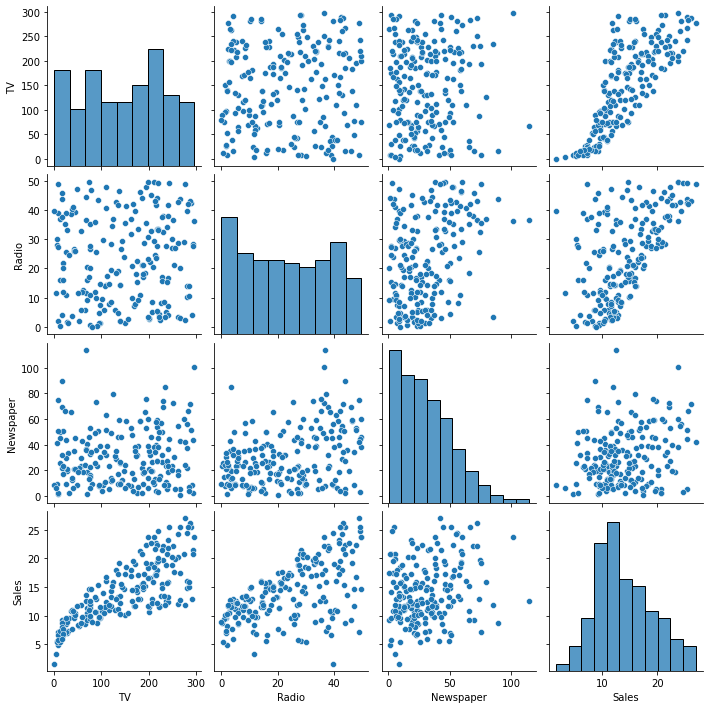

In [7]:
# Data visualization with Seaborn
sns.pairplot(data)

### CORRELATION ANALYSIS

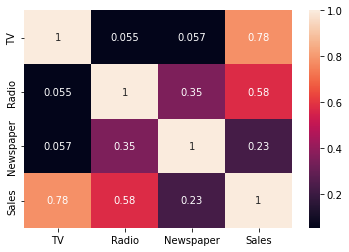

In [8]:
sns.heatmap(data.corr(), annot=True)

The 'Sales' variable shows a linear positive correlation with TV advertising (correlation coefficient of 0.78), a moderate positive correlation with Radio advertising (correlation coefficient of 0.58), and a weak positive correlation with Newspaper ads (correlation coefficient of 0.23).

In [11]:
# Calculate the correlation
correlation = data[['TV', 'Radio', 'Newspaper', 'Sales']].corr()

# Check if the correlation is significant
threshold = 0.5  # Set the threshold for significance, you can adjust it as needed

# Iterate through each variable
for column in correlation.columns[:-1]:  # Exclude 'Sales' column
    corr_value = correlation.loc['Sales', column]
    is_significant = abs(corr_value) >= threshold
    significance = 'significant' if is_significant else 'not significant'
    print(f"Correlation between Sales and {column}: ({corr_value:.2f}) is {significance}.")

Correlation between Sales and TV: (0.78) is significant.
Correlation between Sales and Radio: (0.58) is significant.
Correlation between Sales and Newspaper: (0.23) is not significant.


Based on the observed correlation values, we can infer a significant linear relationship between the variables. This suggests that parametric regression techniques can be employed to predict sales values based on advertising expenditure. However, it is crucial to assess whether the data satisfies the normality assumption required for these tests. To examine the normality of the data, we will employ the Shapiro-Wilk test.

In [13]:
# Shapiro Wilk Test for Normality

sales_data = data['Sales']
statistic, p_value = shapiro(sales_data)

alpha = 0.05  # Significance level

print(f"Shapiro-Wilk Test - p-value: {p_value:.4f}")

if p_value > alpha:
    print("Data is normally distributed.")
else:
    print("Data is not normally distributed.")

Shapiro-Wilk Test - p-value: 0.0017
Data is not normally distributed.


Based on the Shapiro-Wilk test result with a p-value of 0.0017, the data is found to be not normally distributed. Therefore, it does not fulfill the normality assumption required for parametric regression models. Hence, it would be more appropriate to explore non-parametric regression models.

### MODEL SELECTION

In [25]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data.drop('Sales', axis=1), data['Sales'], test_size=0.2, random_state=42)

# Define the models
models = [
    ('Random Forest', RandomForestRegressor()),
    ('Support Vector', SVR()),
    ('Decision Tree', DecisionTreeRegressor()),
    ('Gaussian Process', GaussianProcessRegressor())
]

# Feature selection
k_values = [1, 2, 3]  # Number of top features to select
best_models = []  # Store the best model for each feature selection

for k in k_values:
    # Create pipelines for each model
    pipelines = []
    for name, model in models:
        pipeline = make_pipeline(SelectKBest(f_regression, k=k), model)
        pipelines.append((name, pipeline))

    # Train and evaluate each pipeline
    for name, pipeline in pipelines:
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        best_models.append((name, pipeline, mse))

# Find the best model based on mean squared error
best_model = min(best_models, key=lambda x: x[2])[1]

# Fit the best model on the entire dataset
best_model.fit(data.drop('Sales', axis=1), data['Sales'])

Pipeline(steps=[('selectkbest',
                 SelectKBest(k=2,
                             score_func=<function f_regression at 0x000001C5B25620D0>)),
                ('randomforestregressor', RandomForestRegressor())])

In [32]:
# Create an empty DataFrame to store the MSE values and selected features
mse_table = pd.DataFrame(columns=['Model', 'MSE', 'Selected Features'])

# Calculate the MSE for each model
for name, pipeline, mse in best_models:
    # Extract the selected features
    selected_features = X_train.columns[pipeline.named_steps['selectkbest'].get_support()]
    
    # Append the model, MSE, and selected features to the mse_table DataFrame
    mse_table = mse_table.append({'Model': name, 'MSE': mse, 'Selected Features': selected_features}, ignore_index=True)

# Display the MSE table
mse_table

<ipython-input-32-b0e31fee735a>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse_table = mse_table.append({'Model': name, 'MSE': mse, 'Selected Features': selected_features}, ignore_index=True)
<ipython-input-32-b0e31fee735a>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse_table = mse_table.append({'Model': name, 'MSE': mse, 'Selected Features': selected_features}, ignore_index=True)
<ipython-input-32-b0e31fee735a>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse_table = mse_table.append({'Model': name, 'MSE': mse, 'Selected Features': selected_features}, ignore_index=True)
<ipython-input-32-b0e31fee735a>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

,Model,MSE,Selected Features
0,Random Forest,8.986134,"Index(['TV'], dtype='object')"
1,Support Vector,11.114261,"Index(['TV'], dtype='object')"
2,Decision Tree,11.869500,"Index(['TV'], dtype='object')"
3,Gaussian Process,12918.651407,"Index(['TV'], dtype='object')"
4,Random Forest,0.427814,"Index(['TV', 'Radio'], dtype='object')"
5,Support Vector,3.190222,"Index(['TV', 'Radio'], dtype='object')"
6,Decision Tree,1.196500,"Index(['TV', 'Radio'], dtype='object')"
7,Gaussian Process,190.561269,"Index(['TV', 'Radio'], dtype='object')"
8,Random Forest,0.559419,"Index(['TV', 'Radio', 'Newspaper'], dtype='obj..."
9,Support Vector,4.006045,"Index(['TV', 'Radio', 'Newspaper'], dtype='obj..."


In [33]:
# Predict on the test set using the best model (Random Forest)
y_pred = best_model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)

# Print the MSE of the best model
print("MSE of the Best Model (Random Forest):", mse)

MSE of the Best Model (Random Forest): 0.04835637500000023


In [34]:
# Extract the selected features from the best model
selected_features = X_train.columns[best_model.named_steps['selectkbest'].get_support()]

# Extract the feature importances from the Random Forest model
feature_importances = best_model.named_steps['randomforestregressor'].feature_importances_

# Create a dictionary mapping features to importance scores
feature_importance_dict = dict(zip(selected_features, feature_importances))

# Sort the feature importance dictionary by importance score in descending order
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the selected features and their importance scores
print("Selected Features and Feature Importance:")
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")


Selected Features and Feature Importance:
TV: 0.637921980670703
Radio: 0.36207801932929706


Based on the feature importance scores obtained from the Random Forest model, it can be concluded that TV advertising has a higher impact on sales compared to Radio advertising, while Newspaper advertising appears to have minimal influence. Therefore, the Random Forest model, considering the linear relationships between the variables, remains the best choice for predicting sales.

In [35]:
# Predict on the test set using the best model (Random Forest)
y_pred = best_model.predict(X_test)

# Calculate the R-squared value
r2 = r2_score(y_test, y_pred)

# Print the R-squared value of the best model
print("R-squared of the Best Model (Random Forest):", r2)

R-squared of the Best Model (Random Forest): 0.9984679699218344


The R-squared value of the best model (Random Forest) is 0.9985, which indicates that approximately 99.85% of the variability in the sales data can be explained by the predictor variables (TV and Radio advertising). This high R-squared value suggests that the Random Forest model provides an excellent fit to the data and is capable of accurately predicting sales based on the advertising expenditures.

### Hyperparamter Tuning

In [37]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the Random Forest regressor
rf = RandomForestRegressor()

# Perform Grid Search cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train[['TV', 'Radio']], y_train)

# Retrieve the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_params)

Best Hyperparameters:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [38]:
# Create the Random Forest regressor with the best hyperparameters
rf = RandomForestRegressor(max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100)

# Train the Random Forest model using the selected features
rf.fit(X_train[['TV', 'Radio']], y_train)

# Predict on the test set
y_pred = rf.predict(X_test[['TV', 'Radio']])

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate the R-squared value
r2 = r2_score(y_test, y_pred)

# Print the MSE, RMSE and R-squared value
print("MSE:", mse)
print("RMSE:", rmse)
print("R-squared:", r2)

MSE: 0.45565761522824355
RMSE: 0.67502415899599
R-squared: 0.9855638233454249


### Cross Validation

In [40]:
# Create the Random Forest regressor with the best hyperparameters
rf = RandomForestRegressor(max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100)

# Perform cross-validation
cv_scores = cross_val_score(rf, X_train[['TV', 'Radio']], y_train, cv=5, scoring='neg_mean_squared_error')

# Convert the negative MSE scores to positive
cv_scores = -cv_scores

# Calculate the mean and standard deviation of the MSE scores
mean_mse = cv_scores.mean()
std_mse = cv_scores.std()

# Calculate R-squared
y_pred = rf.fit(X_train[['TV', 'Radio']], y_train).predict(X_test[['TV', 'Radio']])
r_squared = r2_score(y_test, y_pred)

# Print the mean MSE, standard deviation of MSE, and R-squared
print("Mean MSE:", mean_mse)
print("Standard Deviation of MSE:", std_mse)
print("R-squared:", r_squared)

Mean MSE: 0.5832694237983266
Standard Deviation of MSE: 0.24695931035793953
R-squared: 0.9848967806063542


### CONCLUSION

Based on the results obtained from both train-test split and cross-validation, it can be concluded that the selected model, which utilizes TV and Radio advertising as predictors, demonstrates consistent and strong performance in predicting the Sales variable. The mean squared error (MSE) and standard deviation of MSE indicate that the model's predictions are generally close to the actual values, with relatively low variability across different subsets of the data. Additionally, the high R-squared value suggests that the model explains a significant portion of the variance in Sales, indicating a good fit.

Considering these findings, it appears that the model has good generalization capabilities and is less likely to suffer from overfitting. However, it is essential to continue monitoring the model's performance on unseen data and consider other factors, such as the model's complexity and specific requirements of the problem, to make further informed decisions.

Overall, the selected model using TV and Radio advertising as predictors shows promising results for predicting Sales, demonstrating the importance of these advertising channels in driving sales.